### Case Study number of blogposts



#### Results Hits@10 mean and stdderr

##### On hidden layer with 10 nodes
LR                 4.900 0.1690

Poisson       5.483 0.1878

ZI Poisson  5.566 0.1515

##### Two hidden layer with 100, 10 nodes
LR               5.166666666666667 0.15664

Poisson     5.85 0.1868

Zi Poisson 5.666666666666667 0.18358568490

In [110]:
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [111]:
!pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')

Installation of `tensorflow-gpu==2.0.0-alpha0` complete.


In [112]:
 !pip install -q tfp-nightly
 print("Installation of `tfp-nightly` complete.")

Installation of `tfp-nightly` complete.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190422
TF  Version 2.0.0-alpha0


In [8]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [9]:
# Loading to the data
d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
Xu = d[:,0:279]
y = d[:,280]
d.shape, Xu.shape, y.shape

((52397, 281), (52397, 279), (52397,))

In [0]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)

### Definition of a Poisson Model

In [0]:
## Definition of the custom parametrized distribution
def my_poiss(t):
    return tfd.Poisson(rate=t) #Equivalent to log_rate=t when using linear activation 

In [79]:
t = np.ones((3,1), dtype=np.float32)
t
my_poiss(t)

<tfp.distributions.Poisson 'Poisson/' batch_shape=(3, 1) event_shape=() dtype=float32>

In [0]:
IS_GAUSSIAN = False
IS_ZI = False

In [0]:
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(279,))
rate = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dense(10, activation='sigmoid')(rate)
rate = tf.keras.layers.Dense(1, 
                             activation=tf.exp, 
                             bias_initializer='zeros', 
                             kernel_initializer='zeros')(rate)
p_y = tfp.layers.DistributionLambda(my_poiss)(rate) #<------- Here we hand-in the the custom distribution
#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

In [0]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

### Definition of a Gaussian Model

Using Poisson
Train on 47157 samples, validate on 5240 samples
Epoch 1/15
47157/47157 [==============================] - 4s 88us/sample - loss: 13.1408 - val_loss: 4.1305
Epoch 2/15
47157/47157 [==============================] - 5s 101us/sample - loss: 7.4543 - val_loss: 4.0487
Epoch 3/15
47157/47157 [==============================] - 5s 98us/sample - loss: 6.6641 - val_loss: 3.9168
Epoch 4/15
47157/47157 [==============================] - 4s 88us/sample - loss: 6.2235 - val_loss: 3.9193
Epoch 5/15
47157/47157 [==============================] - 4s 84us/sample - loss: 5.7971 - val_loss: 3.8750
Epoch 6/15
47157/47157 [==============================] - 4s 84us/sample - loss: 5.4743 - val_loss: 3.7755
Epoch 7/15
47157/47157 [==============================] - 4s 84us/sample - loss: 5.2765 - val_loss: 3.5840
Epoch 8/15
47157/47157 [==============================] - 4s 85us/sample - loss: 4.9542 - val_loss: 3.6434
Epoch 9/15
47157/47157 [==============================] - 4s 85us/sample - loss

5.64314628768753

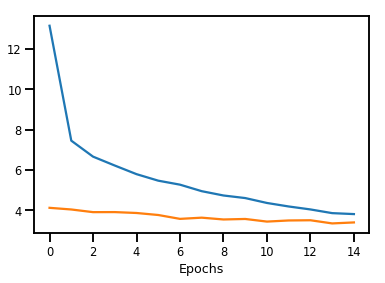

In [117]:
if IS_GAUSSIAN: #Using MSE
  model = tf.keras.models.Model(inputs=inputs, outputs=rate)
  model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
  print("Using Gaussian")
else:
  print("Using Poisson")
  model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)
hist = model.fit(X, y, epochs=15, verbose=1, validation_split=0.1);
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

### Definition of a zero inflated  Model

In [0]:
## Definition of the custom parametrized distribution
def my_zero(t):
    mean = tf.exp(t[:,0]) #Needed so that Poisson has batch_shape=(5,) 
    #print(mean)
    s = tf.math.sigmoid(t[...,1:])
    probs = tf.concat([s, 1-s], axis=1)
    #print(probs)
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#batch_shape=(5,) event_shape=()
          components=[
            tfd.Poisson(rate=mean),   #batch_shape=(5,) event_shape=()
            #tfd.Poisson(rate=0.00001*mean), #Hack to produce 0
            tfd.Deterministic(loc=tf.zeros_like(mean))
        ])

In [102]:
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(279,))

# The mean path
m_h1 = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
m_h2 = tf.keras.layers.Dense(10, activation='sigmoid')(m_h1)
mean = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(m_h2)

# The zero path
z_h1 = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
z_h2 = tf.keras.layers.Dense(10, activation='sigmoid')(z_h1)
z = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(z_h2)

tt = tf.concat([mean, z], axis=1)
p_y_zi = tfp.layers.DistributionLambda(my_zero)(tt)

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi)
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 279)]        0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 100)          28000       input_13[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 100)          28000       input_13[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 10)           1010        dense_29[0][0]                   
___________________________________________________________________________________________

In [103]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))
  
  
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
hist = model.fit(X, y, epochs=15, verbose=1, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/15
47157/47157 [==============================] - 6s 131us/sample - loss: 11.3721 - val_loss: 2.7360
Epoch 2/15
47157/47157 [==============================] - 6s 122us/sample - loss: 6.2122 - val_loss: 2.7095
Epoch 3/15
47157/47157 [==============================] - 6s 122us/sample - loss: 5.6048 - val_loss: 2.6373
Epoch 4/15
47157/47157 [==============================] - 6s 121us/sample - loss: 5.2500 - val_loss: 2.6721
Epoch 5/15
47157/47157 [==============================] - 6s 136us/sample - loss: 4.9442 - val_loss: 2.5585
Epoch 6/15
47157/47157 [==============================] - 7s 149us/sample - loss: 4.6394 - val_loss: 2.6092
Epoch 7/15
47157/47157 [==============================] - 6s 121us/sample - loss: 4.3879 - val_loss: 2.6005
Epoch 8/15
47157/47157 [==============================] - 6s 121us/sample - loss: 4.1695 - val_loss: 2.7264
Epoch 9/15
47157/47157 [==============================] - 6s 121us/sample - loss: 4.02

In [0]:
#model.get_weights()

5.64314628768753

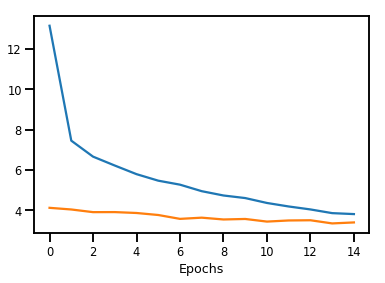

In [118]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

In [119]:
if IS_GAUSSIAN:
  model_mean = model
else:
  #Glueing input and output together. Note that output is a tf.distirbution 
  if IS_ZI:
     model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi.mean())
  else:
    model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean())
    
def check_performance(model_mean):
    files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
    hits_at10 = np.zeros(len(files))
    for i,f in enumerate(files):
        d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
        #print("{}".format(i))
        Xtu = d[:,0:279]
        yt = d[:,280]
        Xt = (Xtu-Xmean) / (Xsd+1e-10)
        d.shape, Xtu.shape, yt.shape
        y_pred = model_mean.predict(Xt).flatten()
        idx_true = np.argsort(yt)[-10:]
        idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
        hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))
    print(np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files)))
    return hits_at10

check_performance(model_mean);

5.85 0.18682285132653817


In [87]:
model_mean.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 279)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                2800      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
_________________________________________________________________
distribution_lambda_7/Poisso [(None, 1)]               0         
_________________________________________________________________
Identity_14 (TensorFlowOpLay [(None, 1)]               0         
Total params: 2,811
Trainable params: 2,811
Non-trainable params: 0
_________________________________________________________________
